<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
%%bash
pip install --no-cache-dir -qU \
  tensorflow-probability[tf]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


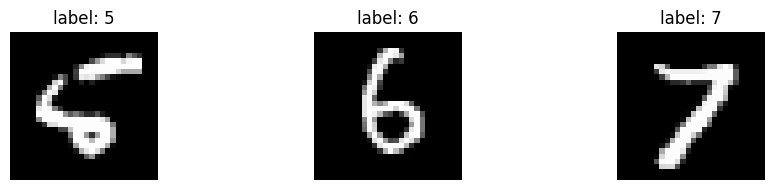

(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [2]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 48s
Test loss: 0.0890, Test acc: 0.9756


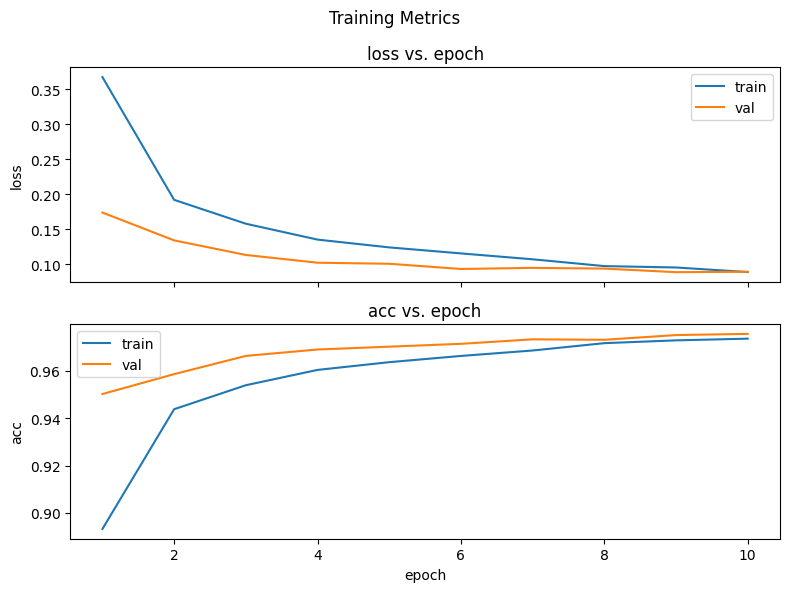

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@keras.saving.register_keras_serializable()
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocess(inputs=inputs)



x = tf.keras.Input(name="Images", shape=(28, 28), dtype=tf.float32)
h = PreprocessingLayer(name="preprocessing")(inputs=x)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = tf.keras.Model(inputs=x, outputs=y)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

class TrainStep(tf.Module):
    def __init__(self, optimizer, **kwargs):
        super().__init__(**kwargs)
        self.optimizier = optimizer

    @tf.function
    def __call__(self, data, model):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = model(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)
        vars = self.trainable_variables
        grads = tape.gradient(target=loss, sources=vars)
        self.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
        for m in self.metrics:
            if m.name=="loss":
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)
        return {m.name: m.result() for m in self.metrics}

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    ode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList

start_time = time.time()
history = model.fit(x=ds_train, validation_data=ds_test,
    epochs=10, verbose=False, callbacks=[


])
print("Training duration: %2.fs"%(time.time() - start_time))
loss, acc = model.evaluate(x=ds_test, verbose=False)
print(f"Test loss: %.4f, Test acc: %.4f"%(loss, acc))

df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
axes[1].set_xlabel(xlabel="epoch")
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=m)
    sns.lineplot(ax=ax, label="val", data=df_history,
        x="epoch", y=f"val_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=m)
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

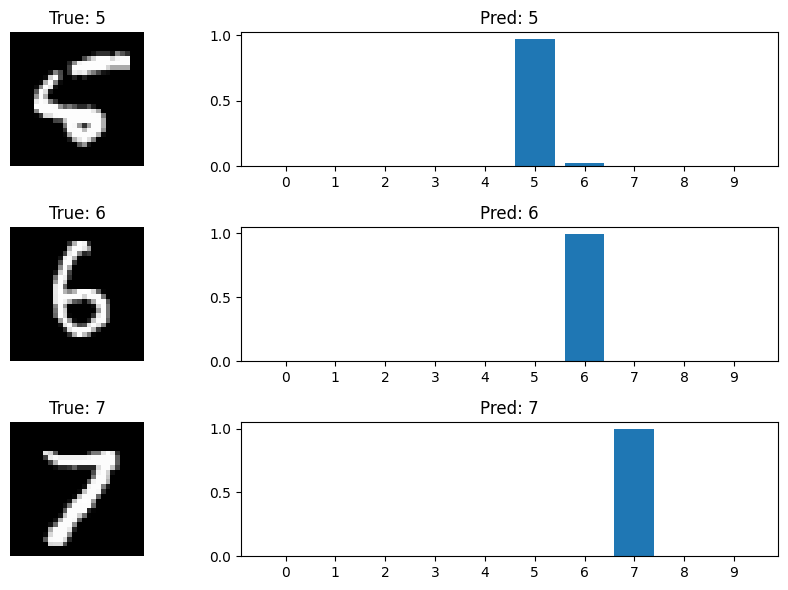

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model.predict(x=x_plt, verbose=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()

## Models with multiple inputs and outputs

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7128 - loss: 0.7131
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7425 - loss: 0.6332
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7618 - loss: 0.5028
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8050 - loss: 0.4009
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8347 - loss: 0.3413


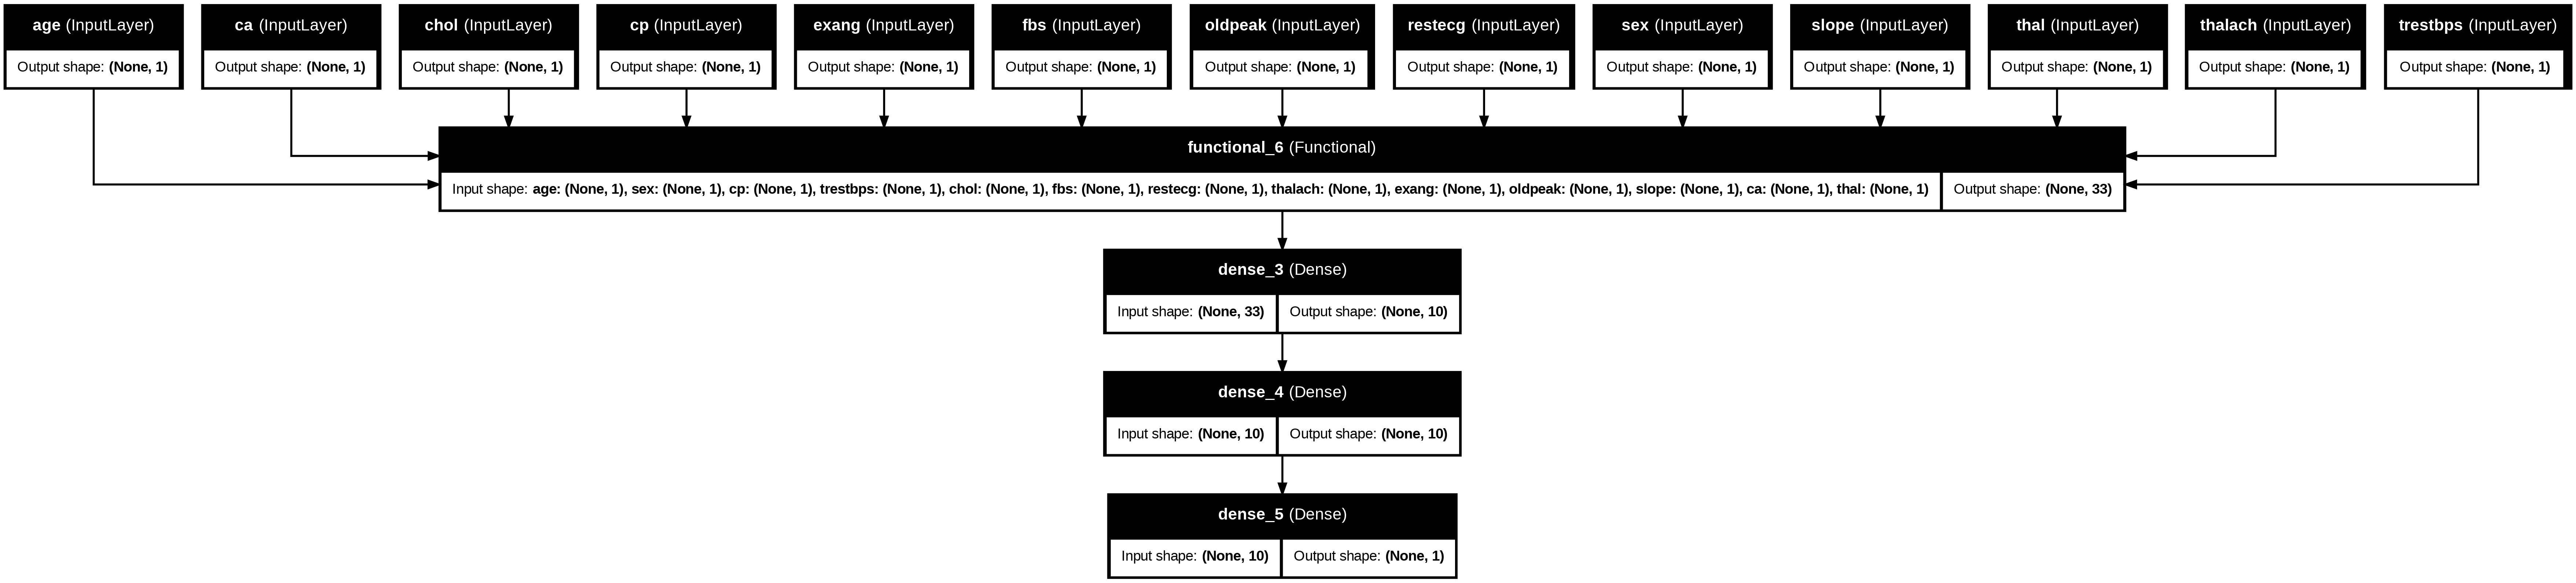

In [ ]:
csv_file = tf.keras.utils.get_file(fname='heart.csv',
    origin='https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

df = pd.read_csv(csv_file)
target = df.pop("target")

binary_cols = ["sex", "fbs", "exang"]
categoric_cols = ["cp", "restecg", "slope", "thal", "ca"]
numeric_cols = ["age", "chol", "oldpeak", "thalach", "trestbps"]

inputs, preprocessed = {}, []
for name, column in df.items():
    dtype = column.dtype
    if dtype==object:
        dtype = tf.string
    elif (name in categoric_cols or name in binary_cols):
        dtype = tf.int64
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=dtype)

for name in binary_cols:
    preprocessed.append(inputs[name])

numeric_inputs = {name:input for name, input in inputs.items()
    if input.dtype==tf.float32}
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(df[numeric_inputs.keys()].values)
numeric_inputs = tf.keras.layers.Concatenate(axis=-1)(
    list(numeric_inputs.values()))
preprocessed.append(normalizer(numeric_inputs))

for name in categoric_cols:
    vocab = sorted(set(df[name]))
    if type(vocab[0])==str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab,
            output_mode="one_hot")
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab,
            output_mode="one_hot")
    preprocessed.append(lookup(inputs[name]))

preprocessed_inputs = tf.keras.layers.Concatenate(axis=1)(preprocessed)
preprocessor = tf.keras.Model(inputs=inputs, outputs=preprocessed_inputs)

x = preprocessor(inputs)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(x)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(h)
predicted_target = tf.keras.layers.Dense(units=1)(h)
model = tf.keras.Model(inputs=inputs, outputs=predicted_target)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

ds = tf.data.Dataset.from_tensor_slices(tensors=(dict(df), target)).cache()
ds = ds.shuffle(buffer_size=len(target)).batch(batch_size=4)
history = model.fit(x=ds, epochs=5, batch_size=2)
# print(model(dict(df.iloc[:3])), target[:3])

tf.keras.utils.plot_model(model=model,
    show_layer_names=True, show_shapes=True)

In [ ]:
# class CustomModel(tf.keras.Model):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#         self.normalizer = tf.keras.layers.Normalization(axis=-1)

#         self.concat = tf.keras.layers.Concatenate(axis=1)

#         self.classifier = tf.keras.Sequential(layers=[
#             self.normalizer,
#             tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
#             tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu),
#             tf.keras.layers.Dense(units=1)
#         ])

#     def _stack(self, input_dict):
#         values = [v for _, v in sorted(input_dict.items())]
#         return self.concat(values)

#     def adapt(self, inputs):
#         inputs = self._stack(inputs)
#         self.normalizer.adapt(inputs)

#     def call(self, inputs):
#         inputs = self._stack(inputs)
#         return self.classifier(inputs)

# model = CustomModel()
# model.adapt(features)

In [ ]:
origin = "https://archive.ics.uci.edu/static/public/492/metro+interstate+traffic+volume.zip"
fname = "Metro_Interstate_Traffic_Volume.csv.gz"
tf.keras.utils.get_file(origin=origin, fname=fname, extract=True, cache_dir=".")

file_name = "datasets/Metro_Interstate_Traffic_Volume_extracted/Metro_Interstate_Traffic_Volume.csv.gz"
df_data = pd.read_csv(file_name, compression="gzip")
df_data["date_time"] = pd.to_datetime(df_data["date_time"])
df_data.sort_values(by=["date_time"], inplace=True)
df_data["holiday"] = np.where(df_data["holiday"].notnull(), 1, 0).astype(np.int64)
df_data["weekday"] = df_data["date_time"].dt.strftime("%A")
df_data["hour"] = df_data["date_time"].dt.hour
df_data.drop(columns=["date_time"], inplace=True)

df_train, df_test = model_selection.train_test_split(df_data, test_size=0.1,
    random_state=42)

def get_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df)).cache()
    ds = ds.map(map_func=lambda x: {k: tf.reshape(tensor=v, shape=(1,))
        for k, v in x.items()})
    ds = ds.map(map_func=lambda x: (x,
        {"weather_main": x.pop("weather_main"), "traffic_volume": x.pop("traffic_volume")}))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=32)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(df=df_train, shuffle=True)
ds_test = get_ds(df=df_test, shuffle=False)
ds_test.element_spec